# Final forecast analysis

Use this notebook after running 'final' notebooks to produce actual forecasts.

In [190]:
import numpy as np
import pandas as pd
import pathlib
import os

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_pinball_loss

## Set analysis configurations

Read experiment results from the 6-year ensemble file.

In [191]:
ensemble_file = "./output/Full_Report/best_results_ensembles_llmp_final.csv"
exp_results = pd.read_csv(ensemble_file)
exp_results

random_seed = 42

forecast_start = "2024-07-01"

forecast_gen_start = "2024-08-01"
directory_to_lookup = 'Forecasts'

In [192]:
forecast_configs = exp_results[['category', "top_experiment"]].set_index("category")
forecast_configs = forecast_configs.to_dict()['top_experiment']
forecast_configs = {cat: config.split('+') for cat, config in forecast_configs.items()}
forecast_configs

# Modifying Food category based on manual inspection
if 'llmp_final' in ensemble_file:
    forecast_configs['food_cpi: Food'] = ['ag_global_all_ChronosModel']
    
forecast_configs


{'food_cpi: Bakery and cereal products (excluding baby food)': ['claude-3-5-sonnet-20240620_report_True',
  'ag_global_all_ChronosModel',
  'ag_local_PatchTSTModel',
  'ag_local_ChronosModel'],
 'food_cpi: Dairy products and eggs': ['ag_local_ChronosModel',
  'ag_global_all_ChronosModel',
  'ag_local_TemporalFusionTransformerModel'],
 'food_cpi: Fish, seafood and other marine products': ['ag_local_AutoETSModel',
  'ag_global_all_TemporalFusionTransformerModel_exp1_llm_',
  'ag_global_cpi_with_covariates_TemporalFusionTransformerModel'],
 'food_cpi: Food purchased from restaurants': ['ag_global_all_ChronosModel'],
 'food_cpi: Food': ['ag_global_all_ChronosModel'],
 'food_cpi: Fruit, fruit preparations and nuts': ['ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
  'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
  'ag_global_all_TemporalFusionTransformerModel_exp1_llm_'],
 'food_cpi: Meat': ['claude-3-5-sonnet-20240620_report_True',
  'ag_global_all

In [193]:
all_exp_names = []
for cat, exp in forecast_configs.items():
    all_exp_names.extend(exp)
all_exp_names = list(set(all_exp_names))
all_exp_names

['ag_local_TemporalFusionTransformerModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp5_climate_',
 'ag_global_all_TemporalFusionTransformerModel_exp5_geopolitical_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'ag_global_all_SimpleFeedForwardModel_exp5_geopolitical_',
 'ag_local_PatchTSTModel',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'ag_local_AutoETSModel',
 'ag_local_ChronosModel',
 'ag_global_all_ChronosModel',
 'claude-3-5-sonnet-20240620_report_True',
 'ag_global_all_TemporalFusionTransformerModel_exp1_llm_']

In [194]:
target_categories = [
    'Bakery and cereal products (excluding baby food)',
     'Dairy products and eggs',
     'Fish, seafood and other marine products',
     'Food purchased from restaurants',
     'Food',
     'Fruit, fruit preparations and nuts',
     'Meat',
     'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]


## Load target data

In [195]:
foodprice_df = pd.read_csv("../data/processed_data/all_data_processed.csv", index_col=0)[target_categories]
foodprice_df.index = pd.to_datetime(foodprice_df.index)
foodprice_df.tail()

,food_cpi: Bakery and cereal products (excluding baby food),food_cpi: Dairy products and eggs,"food_cpi: Fish, seafood and other marine products",food_cpi: Food purchased from restaurants,food_cpi: Food,"food_cpi: Fruit, fruit preparations and nuts",food_cpi: Meat,food_cpi: Other food products and non-alcoholic beverages,food_cpi: Vegetables and vegetable preparations
2024-05-01,198.8,171.0,160.8,194.2,189.0,168.8,210.2,177.9,189.7
2024-06-01,198.2,173.7,161.0,195.0,190.0,171.0,211.3,178.5,190.2
2024-07-01,199.1,174.4,162.1,195.3,190.5,168.8,212.8,177.9,194.7
2024-08-01,198.4,174.4,162.1,195.5,190.3,168.3,212.5,179.5,189.8
2024-09-01,196.4,174.2,162.5,196.0,190.3,168.9,214.0,179.1,188.2


## Format forecast results

In [196]:
def get_mean_ensemble_forecast(category, exp_config):
    global forecast_df
    ensemble_experiments = exp_config

    # Generate the mean forecast
    forecast_dfs = []
    for exp_name in ensemble_experiments:
        forecast_csv_path = f"./output/{directory_to_lookup}/{exp_name}/random_seed_{random_seed}/{forecast_start}/forecasts/{category}.csv"

#         forecast_csv_path = f"./output/Forecasts/{exp_name}/random_seed_{random_seed}/{forecast_start}/forecasts/{category}.csv"
        forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
        forecast_df.index = pd.to_datetime(forecast_df.index)
        forecast_df = forecast_df[['q_0.05', 'q_0.5', 'q_0.95']]
        forecast_df = forecast_df.loc[forecast_df.index<='2025-07-01']
        forecast_dfs.append(forecast_df)

    # aggregate the forecasts
    mean_forecast_values = np.sum([df.values / len(ensemble_experiments) for df in forecast_dfs], axis=0)
    forecast_df = pd.DataFrame(mean_forecast_values, index=forecast_df.index, columns=forecast_df.columns)
    return forecast_df, forecast_dfs

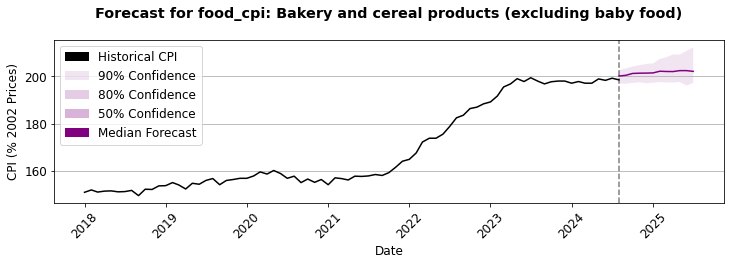

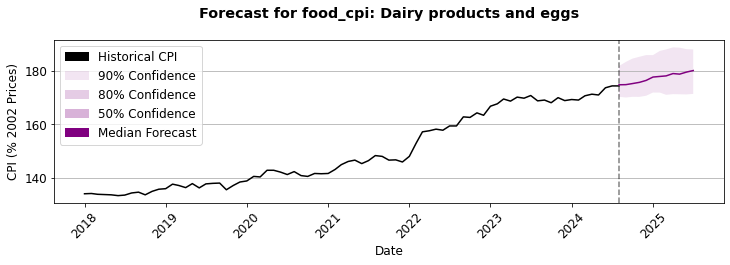

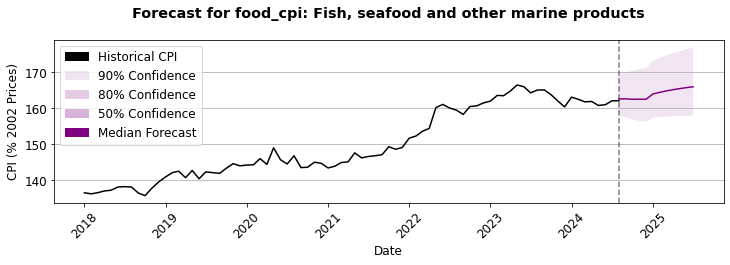

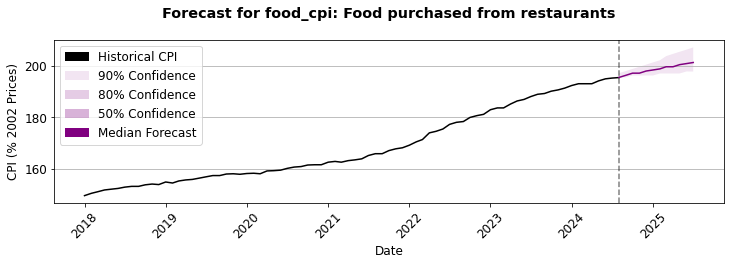

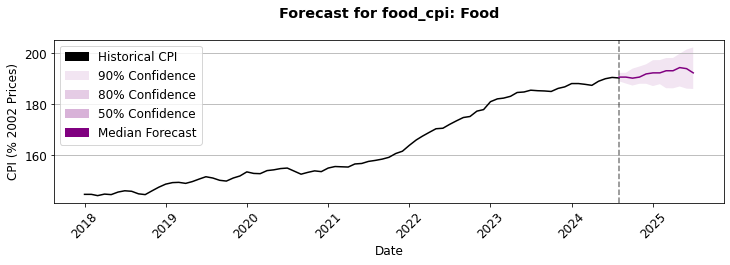

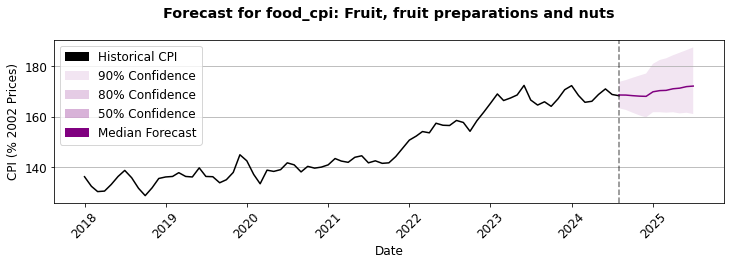

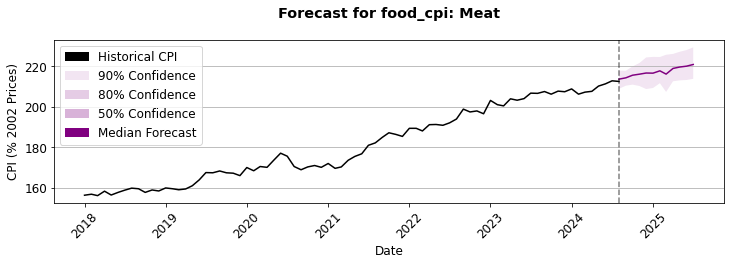

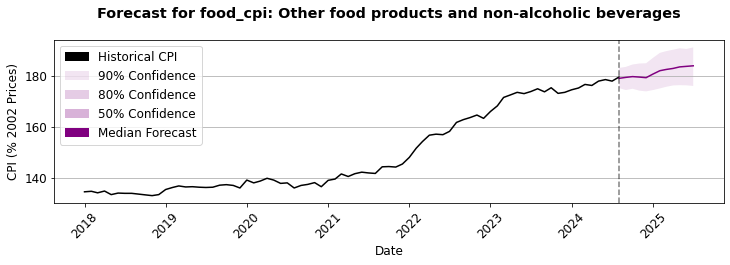

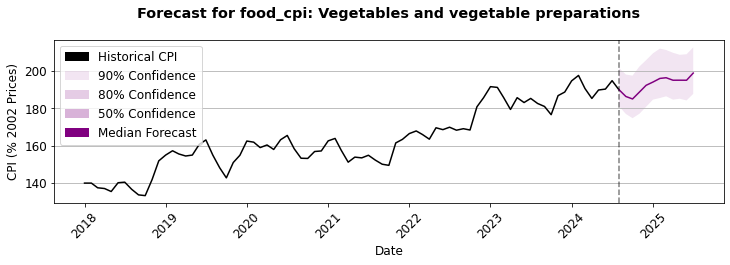

In [197]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.patches import Patch

all_pred_price_quantiles = {}

for category, config in forecast_configs.items():

    forecast_df, _ = get_mean_ensemble_forecast(category, config)

    fig, ax = plt.subplots(figsize=(12,3))

    # Context
    context_df = foodprice_df[category].loc[(foodprice_df.index >= "2018-01-01") & (foodprice_df.index <= forecast_gen_start)]
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    base_alpha = 0.1
    colors = ['purple', 'purple', 'purple']  # all the same color in this case, but can be different
    alphas = [0.1, 0.2, 0.3]  # Effective alpha for each layer
    labels = ['90% Confidence', '80% Confidence', '50% Confidence']  # Labels for the legend

    # Confidence range between 0.01 and 0.99 quantiles
    ax.fill_between(
        forecast_df.index,
        forecast_df[f"q_0.05"],
        forecast_df[f"q_0.95"],
        facecolor=colors[0],
        alpha=base_alpha,
        label=labels[0]
    )

#     ax.fill_between(
#         forecast_df.index,
#         forecast_df[f"q_0.1"],
#         forecast_df[f"q_0.9"],
#         facecolor=colors[1],
#         alpha=base_alpha
#     )

#     ax.fill_between(
#         forecast_df.index,
#         forecast_df[f"q_0.25"],
#         forecast_df[f"q_0.75"],
#         facecolor=colors[2],
#         alpha=base_alpha
#     )

    # Add a line trace for the median
    ax.plot(
        forecast_df.index, 
        forecast_df[f"q_0.5"], 
        color='purple', 
        label='Median Forecast'
        )

    # Create custom legend elements
    legend_elements = [Patch(facecolor='black', label='Historical CPI')] + [
        Patch(facecolor=colors[i], alpha=alphas[i], label=labels[i]) for i in range(3)
    ] + [Patch(facecolor='purple', label='Median Forecast')]


    fc_price_quantiles = forecast_df.iloc[:12].mean()
    ref_price = foodprice_df[category].iloc[-12:].mean()

    pred_price_quantiles = (fc_price_quantiles - ref_price) / ref_price * 100  # Compute year-over-year percent change
    all_pred_price_quantiles[category] = pred_price_quantiles
    
    
    # Update the layout as needed
    config_str = "\n".join(config)
    # ax.set_title(f'{category}\nRetrospective Forecast\n{config_str}')
    ax.set_title(f"Forecast for {category}\n")
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    ax.axvline(pd.to_datetime("2024-08-01"), color='black', ls='--', ms=1, alpha=0.5)
    ax.legend(handles=legend_elements, loc='upper left')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')
    plt.show()

    # Save the figure
    fig.savefig(f"./output/final_output_forecasts/ensemble_forecast_{category}.png", dpi=300, transparent=True, bbox_inches='tight') # High res for png
    

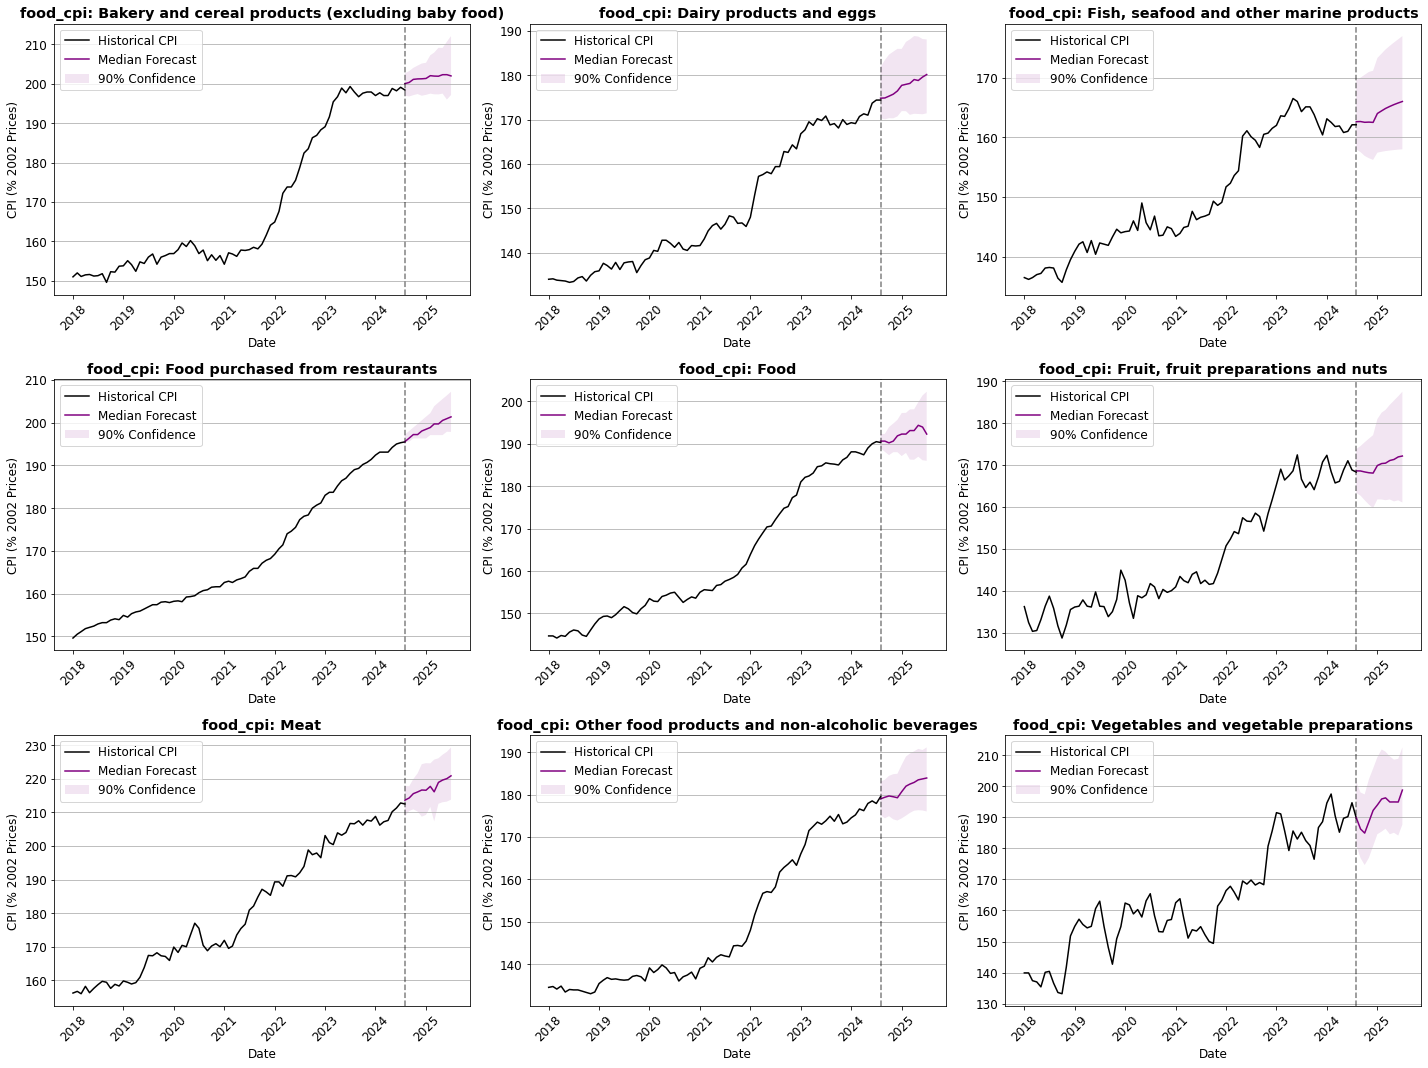

In [198]:
import matplotlib.pyplot as plt

# Modify the default parameters before creating your plots
plt.rcParams['font.size'] = 12  # Assuming the default is 6, which is doubled to 12
plt.rcParams['axes.titlesize'] = 'large'   # Make the title font size relatively larger
plt.rcParams['axes.titleweight'] = 'bold'  # Make the title bold

import matplotlib.dates as mdates
import pandas as pd
from matplotlib.patches import Patch

# Define the number of rows and columns for the subplot grid
nrows = 3
ncols = 3

# Create the subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))  # Adjust the figure size to fit the subplots neatly

all_pred_price_quantiles = {}

# Assume that forecast_configs is a dictionary that holds 9 items
for idx, (category, config) in enumerate(forecast_configs.items()):
    ax = axes[idx // ncols, idx % ncols]  # Determine the current axis

    forecast_df, _ = get_mean_ensemble_forecast(category, config)

    # Context
    context_df = foodprice_df[category].loc[(foodprice_df.index >= "2018-01-01") & (foodprice_df.index <= forecast_gen_start)]
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    base_alpha = 0.1
    colors = ['purple', 'purple', 'purple']  # all the same color in this case, but can be different
    alphas = [0.1, 0.2, 0.3]  # Effective alpha for each layer
    labels = ['90% Confidence', '80% Confidence', '50% Confidence']  # Labels for the legend

    # Confidence range between 0.01 and 0.99 quantiles
    ax.fill_between(
        forecast_df.index,
        forecast_df[f"q_0.05"],
        forecast_df[f"q_0.95"],
        facecolor=colors[0],
        alpha=base_alpha,
        label=labels[0]
    )

#     ax.fill_between(
#         forecast_df.index,
#         forecast_df[f"q_0.1"],
#         forecast_df[f"q_0.9"],
#         facecolor=colors[1],
#         alpha=base_alpha
#     )

#     ax.fill_between(
#         forecast_df.index,
#         forecast_df[f"q_0.25"],
#         forecast_df[f"q_0.75"],
#         facecolor=colors[2],
#         alpha=base_alpha
#     )

    # Add a line trace for the median
    ax.plot(
        forecast_df.index, 
        forecast_df[f"q_0.5"], 
        color='purple', 
        label='Median Forecast'
    )

    # Since there are multiple plots, the legend and title are set for each subplot
    ax.legend(loc='upper left')
    ax.grid(axis='y')
    config_str = "\n".join(config)
    # ax.set_title(f'{category}\nRetrospective Forecast\n{config_str}')
    ax.set_title(f'{category}')
    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    ax.axvline(pd.to_datetime(forecast_gen_start), color='black', ls='--', ms=1, alpha=0.5)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45)

    # Compute year-over-year percent change
    fc_price_quantiles = forecast_df.iloc[:12].mean()
    ref_price = foodprice_df[category].iloc[-12:].mean()
    pred_price_quantiles = (fc_price_quantiles - ref_price) / ref_price * 100
    all_pred_price_quantiles[category] = pred_price_quantiles

# Adjust the layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("./output/final_output_forecasts/ensemble_forecasts_combined.png", dpi=300, transparent=True)  # High res for png


## How to convert and share results?

There are a lot of different ways we could choose to present results, but here's what we know.

Statistics Canada published CPI as a % of 2002 prices, but discussion around inflation is almost ALWAYS using year-over-year percent change, and the expectation is that we present a single year-over-year percent change figure for each major food category.

The problem is that we have predictions for each month. Do we show:
- The predicted average year-over-year change, by month? (plus 95% CIs?) (last year's mean CPI -> mean predicted CPI?)
- How high prices are expected to rise at any point in the year, i.e. last year's observed max -> new predicted max for 2024?

If we take the mean-to-mean approach, I think we need to be careful about which dates we select for the analysis. At the time of writing, there is only CPI data available up to 2023-06-01. So we really only have 6 months of 2023 data to compare to. For the mean-to-mean approach, should we just assume that we want to use the mean of the last 12 CPI observations and compare these to the next predicted 12? To me this doesn't sound too bad.

Using multiple comparisions could be helpful.
Showing predictions over time also useful.

In [210]:
# Our official forecast compares the expected CPI in 2024 to the actual observed CPI in 2023
# Since actual data is only available up to September 2023, we compare means using Jan to Sept.

results = {}
for category, config in forecast_configs.items():

    forecast_df, _ = get_mean_ensemble_forecast(category, config)

    fc_price = forecast_df.loc[(forecast_df.index >= "2025-01-01") &  (forecast_df.index <= "2025-09-01")].mean()  
    ref_price = foodprice_df[category].loc[(foodprice_df.index >= "2024-01-01") & (foodprice_df.index <= "2024-09-01")].mean()  

    fc_series = (fc_price - ref_price) / ref_price * 100  # Compute year-over-year percent change
    results[category] = fc_series

results_df = pd.DataFrame(results).T
results_df = results_df[results_df.columns.sort_values()]
results_df

,q_0.05,q_0.5,q_0.95
food_cpi: Bakery and cereal products (excluding baby food),-0.308608,2.143010,5.583815
food_cpi: Dairy products and eggs,-0.333299,3.930163,9.239753
"food_cpi: Fish, seafood and other marine products",-2.609401,1.924175,8.181153
food_cpi: Food purchased from restaurants,1.545270,2.956424,5.294131
food_cpi: Food,-1.275093,2.116262,5.354167
"food_cpi: Fruit, fruit preparations and nuts",-4.245259,1.366325,9.251396
food_cpi: Meat,0.698256,4.044028,7.830911
food_cpi: Other food products and non-alcoholic beverages,-0.888401,3.079433,7.048376
food_cpi: Vegetables and vegetable preparations,-3.024973,2.364417,9.998257


In [214]:
fc_price

q_0.05    185.373151
q_0.5     195.675271
q_0.95    210.267780
dtype: float64

In [211]:
std = ((results_df['q_0.95'] - results_df['q_0.5']) + (results_df['q_0.5'] - results_df['q_0.05'])) / 2
std

food_cpi: Bakery and cereal products (excluding baby food)    2.946211
food_cpi: Dairy products and eggs                             4.786526
food_cpi: Fish, seafood and other marine products             5.395277
food_cpi: Food purchased from restaurants                     1.874431
food_cpi: Food                                                3.314630
food_cpi: Fruit, fruit preparations and nuts                  6.748327
food_cpi: Meat                                                3.566328
food_cpi: Other food products and non-alcoholic beverages     3.968388
food_cpi: Vegetables and vegetable preparations               6.511615
dtype: float64

In [212]:
# Mapping the categories in the quantile table to those in the forecast data
common_names = ['Bakery',
    'Dairy Products and Eggs',
    'Fish & Seafood',
    'Food at Restaurants',
    'Total Food Categories',
    'Fruit',
    'Meat',
    'Other',
    'Vegetables']

YoY= pd.DataFrame()
YoY['mean'] = results_df['q_0.5']
YoY['std'] = std.values
YoY['common_name'] = common_names
# YoY['mean_round'] = f"{np.round(YoY['mean'].values, 2)} +/- {np.round(YoY['std'].values, 2)}"
YoY['mean_round'] = YoY.apply(lambda row: f"{np.round(row['mean'], 1)}% +/- {np.round(row['std'], 1)}%", axis=1)

YoY

,mean,std,common_name,mean_round
food_cpi: Bakery and cereal products (excluding baby food),2.143010,2.946211,Bakery,2.1% +/- 2.9%
food_cpi: Dairy products and eggs,3.930163,4.786526,Dairy Products and Eggs,3.9% +/- 4.8%
"food_cpi: Fish, seafood and other marine products",1.924175,5.395277,Fish & Seafood,1.9% +/- 5.4%
food_cpi: Food purchased from restaurants,2.956424,1.874431,Food at Restaurants,3.0% +/- 1.9%
food_cpi: Food,2.116262,3.314630,Total Food Categories,2.1% +/- 3.3%
"food_cpi: Fruit, fruit preparations and nuts",1.366325,6.748327,Fruit,1.4% +/- 6.7%
food_cpi: Meat,4.044028,3.566328,Meat,4.0% +/- 3.6%
food_cpi: Other food products and non-alcoholic beverages,3.079433,3.968388,Other,3.1% +/- 4.0%
food_cpi: Vegetables and vegetable preparations,2.364417,6.511615,Vegetables,2.4% +/- 6.5%


## Compute actual percent change (for comparing to last year's forecasts)

In [202]:
## Actual percent change from 2020 to 2021 (Up to September, 2021)

p1 = foodprice_df.loc[foodprice_df.index <= "2023-09-01"]
p1 = p1.loc[p1.index >= "2023-01-01"]
p1 = p1.mean(axis=0).rename("2023 Mean CPI (Jan to Sept)")

p2 = foodprice_df.loc[foodprice_df.index <= "2024-09-01"]
p2 = p2.loc[p2.index >= "2024-01-01"]
p2 = p2.mean(axis=0).rename("2024 Mean CPI (Jan to Sept)")

result = (((p2-p1) / p1) * 100).rename("Actual Mean YoY Percent Change")
pd.concat((p1, p2, result), axis=1)

,2023 Mean CPI (Jan to Sept),2024 Mean CPI (Jan to Sept),Actual Mean YoY Percent Change
food_cpi: Bakery and cereal products (excluding baby food),195.922222,197.733333,0.924403
food_cpi: Dairy products and eggs,169.044444,172.011111,1.754963
"food_cpi: Fish, seafood and other marine products",164.544444,161.977778,-1.559862
food_cpi: Food purchased from restaurants,186.155556,194.188889,4.315387
food_cpi: Food,183.777778,189.055556,2.871826
"food_cpi: Fruit, fruit preparations and nuts",167.355556,168.700000,0.803346
food_cpi: Meat,204.044444,210.066667,2.951427
food_cpi: Other food products and non-alcoholic beverages,171.900000,177.266667,3.121970
food_cpi: Vegetables and vegetable preparations,184.977778,191.155556,3.339741


In [203]:
# Create the equivalent table for this years forecasts

# Let's also plot the ensemble member forecasts

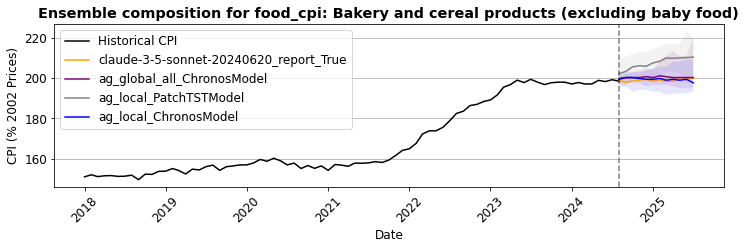

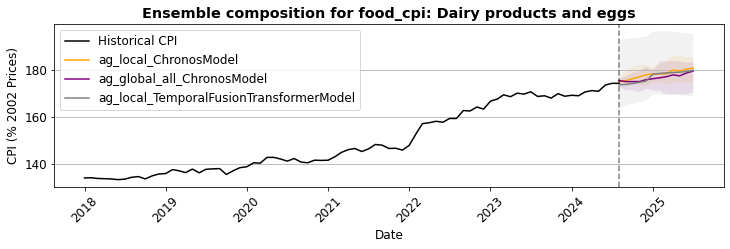

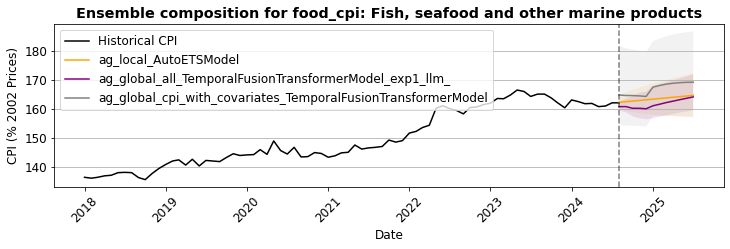

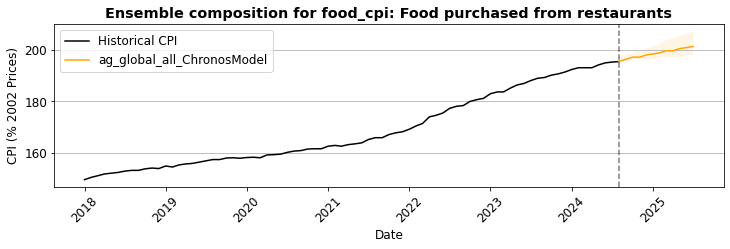

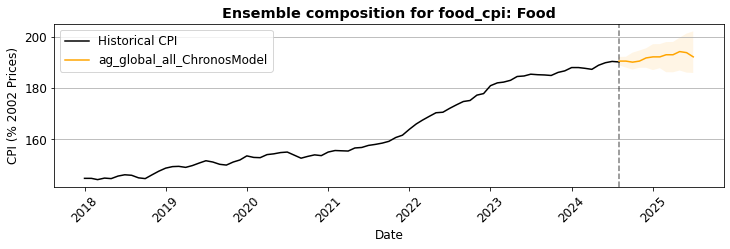

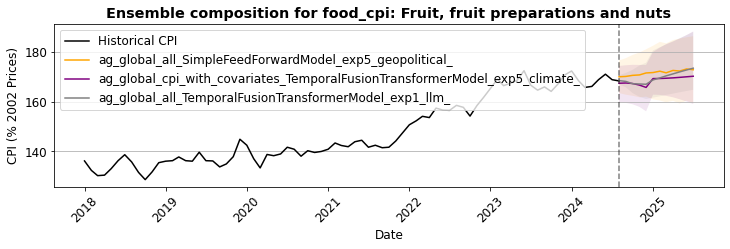

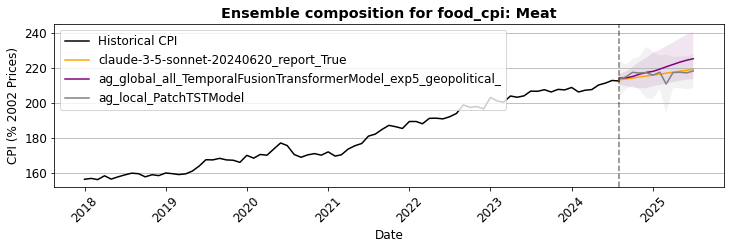

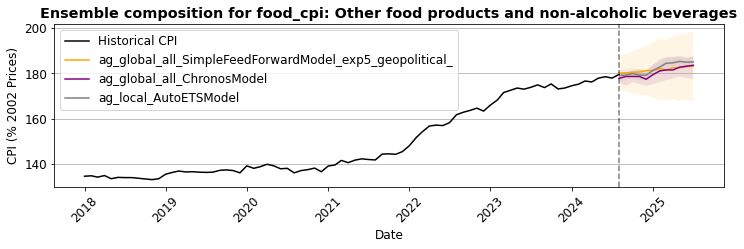

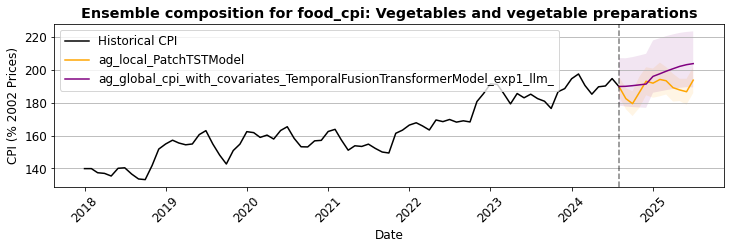

In [204]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.patches import Patch

all_pred_price_quantiles = {}

for category, config in forecast_configs.items():

    _, forecast_dfs = get_mean_ensemble_forecast(category, config)

    fig, ax = plt.subplots(figsize=(12,3))

    # Context
    context_df = foodprice_df[category].loc[(foodprice_df.index >= "2018-01-01") & (foodprice_df.index <= forecast_gen_start)]
    ax.plot(context_df.index, context_df.values, color='black', label='Historical CPI')

    base_alpha = 0.1
    colors = [ 'orange', 'purple', 'grey', 'blue']  # all the same color in this case, but can be different
    alphas = [0.1, 0.2, 0.3]  # Effective alpha for each layer
    labels = ['95% Confidence', '80% Confidence', '50% Confidence']  # Labels for the legend

    for index, forecast_df in enumerate(forecast_dfs):
    
        # Confidence range between 0.01 and 0.99 quantiles
        ax.fill_between(
            forecast_df.index,
            forecast_df[f"q_0.05"],
            forecast_df[f"q_0.95"],
            facecolor=colors[index % len(colors)], 
            alpha=base_alpha,
            # label=labels[0]
        )

#         ax.fill_between(
#             forecast_df.index,
#             forecast_df[f"q_0.1"],
#             forecast_df[f"q_0.9"],
#             facecolor=colors[index % len(colors)], 
#             alpha=base_alpha
#         )

#         ax.fill_between(
#             forecast_df.index,
#             forecast_df[f"q_0.25"],
#             forecast_df[f"q_0.75"],
#             facecolor=colors[index % len(colors)], 
#             alpha=base_alpha
#         )

        # Add a line trace for the median
        ax.plot(
            forecast_df.index, 
            forecast_df[f"q_0.5"], 
            color=colors[index % len(colors)], 
            label=config[index]
            )

        # Create custom legend elements
        # legend_elements = [Patch(facecolor='black', label='Historical CPI')] + [
        #     Patch(facecolor=colors[i], alpha=alphas[i], label=labels[i]) for i in range(3)
        # ] + [Patch(facecolor='purple', label='Median Forecast')]

    # Update the layout as needed
    config_str = "\n".join(config)
#     ax.set_title(f'{category}\nRetrospective Forecast\n{config_str}')
    ax.set_title(f'Ensemble composition for {category}')

    ax.set_xlabel('Date')
    ax.set_ylabel('CPI (% 2002 Prices)')
    ax.axvline(pd.to_datetime(forecast_gen_start), color='black', ls='--', ms=1, alpha=0.5)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')
    plt.show()

    # Save the figure
    fig.savefig(f"./output/final_output_forecasts/all_models_forecast_{category}.png", dpi=300, transparent=True,  bbox_inches='tight') # High res for png
    
    # fc_price_quantiles = forecast_df.iloc[:12].mean()
    # ref_price = foodprice_df[category].iloc[-12:].mean()

    # pred_price_quantiles = (fc_price_quantiles - ref_price) / ref_price * 100  # Compute year-over-year percent change
    # all_pred_price_quantiles[category] = pred_price_quantiles
